# Install packages

In [ ]:
!conda install -y tensorflow scikit-learn pandas seaborn matplotlib

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [29]:
print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("Seaborn version: {}".format(sns.__version__))

Pandas version: 1.2.4
Numpy version: 1.19.2
Tensorflow version: 2.4.1
Seaborn version: 0.11.1


In [30]:
data = pd.read_csv("data/ITC.NS.csv")
data.dropna(inplace=True)
print(data.head())
print(data.size)

         Date      Open      High       Low     Close  Adj Close      Volume
0  1996-01-01  5.550000  5.600000  5.533333  5.583333   3.633695    985500.0
1  1996-01-02  5.466666  5.566666  5.288888  5.372222   3.496303   7470000.0
2  1996-01-03  5.133333  5.254444  5.101111  5.200000   3.384218  15160500.0
3  1996-01-04  5.200000  5.332222  5.144444  5.297777   3.447852  12397500.0
4  1996-01-05  5.297777  5.277777  5.188888  5.202222   3.385664   5008500.0
44541


<AxesSubplot:>

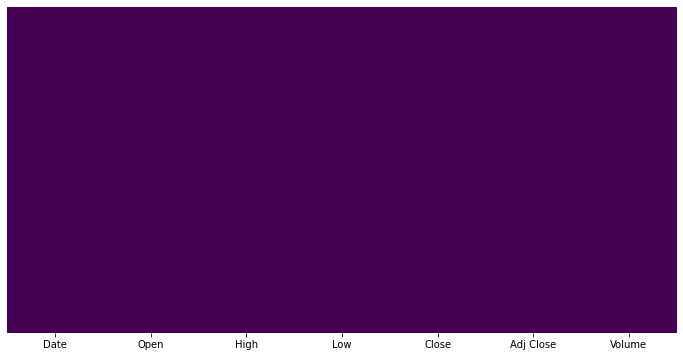

In [31]:
# Check for null values
plt.figure(figsize=(12,6))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [32]:
# Convert Date to Date Time format
data['Date'] = pd.to_datetime(data.Date)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,5.550000,5.600000,5.533333,5.583333,3.633695,985500.0
1,1996-01-02,5.466666,5.566666,5.288888,5.372222,3.496303,7470000.0
2,1996-01-03,5.133333,5.254444,5.101111,5.200000,3.384218,15160500.0
3,1996-01-04,5.200000,5.332222,5.144444,5.297777,3.447852,12397500.0
4,1996-01-05,5.297777,5.277777,5.188888,5.202222,3.385664,5008500.0


In [33]:
# Format prices from String to Float
data['Open'] = data['Open'].replace({'\$':''}, regex=True).astype(float)
data['High'] = data['High'].replace({'\$': ''}, regex=True).astype(float)
data['Close'] = data['Close'].replace({'\$': ''}, regex=True).astype(float)
data['Adj Close'] = data['Adj Close'].replace({'\$': ''}, regex=True).astype(float)
data['Low'] = data['Low'].replace({'\$': ''}, regex=True).astype(float)

# Remove Space from our columns
# data.rename(columns={' Close/Last': 'Close/Last', ' Volume': 'Volume',
#  ' Open': 'Open', ' High': 'High', ' Low': 'Low'},
#  inplace=True)

# Split into train and test:

In [34]:
data_to_train = data[:3000]
data_to_test = data[3000:]

# Export train and test data to csv files

In [35]:
data_to_train.to_csv('data/train_data.csv')
data_to_test.to_csv('data/test_data.csv')

# Model Creation

In [36]:
# Take values from Close column in our model.
training_set = data_to_train.iloc[: , 4:5].values

In [37]:
# Store real stock price to compare with our predictions later.
real_stock_price = data_to_test.iloc[: , 4:5].values

In [49]:
# Scale the training set to increase the performance of our model.
# Scale between 0 and 1

sc = MinMaxScaler(feature_range=(0,1))

training_data_scaled = sc.fit_transform(training_set)

In [50]:
# Format the training data into 3D array to fit into our LSTM model. Create 60 timespams

X_train = []
y_train = []

for i in range(120, 3000):
    X_train.append(training_data_scaled[i-120:i,0])
    y_train.append(training_data_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping

In [51]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Building LSTM Model

In [52]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=1))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=1))

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 120, 50)           10400     
_________________________________________________________________
dropout_15 (Dropout)         (None, 120, 50)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 120, 50)           20200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 120, 50)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 120, 50)           20200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 120, 50)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 120, 50)          

In [53]:
!rm -rf logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 952), started 23:15:14 ago. (Use '!kill 952' to kill it.)

# Fitting

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

modelo = model.fit(X_train, y_train, epochs=200, batch_size=32, callbacks=[tensorboard_callback])

Epoch 1/200
90/90 [==============================] - 333s 3s/step - loss: 0.0578
Epoch 2/200
90/90 [==============================] - 93s 1s/step - loss: 0.0229
Epoch 3/200
90/90 [==============================] - 76s 841ms/step - loss: 0.0175
Epoch 4/200
59/90 [==================>...........] - ETA: 1:46 - loss: 0.0190

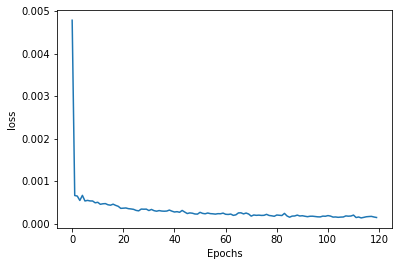

In [44]:
plt.plot(modelo.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

# Making Predictions

In [45]:
dataset_total = pd.concat([data_to_train['Close'], data_to_test['Close']], axis=0)
inputs = dataset_total[len(dataset_total) - len(data_to_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 259):
   X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict

In [46]:
predicted_stock_price = model.predict(X_test)

In [47]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

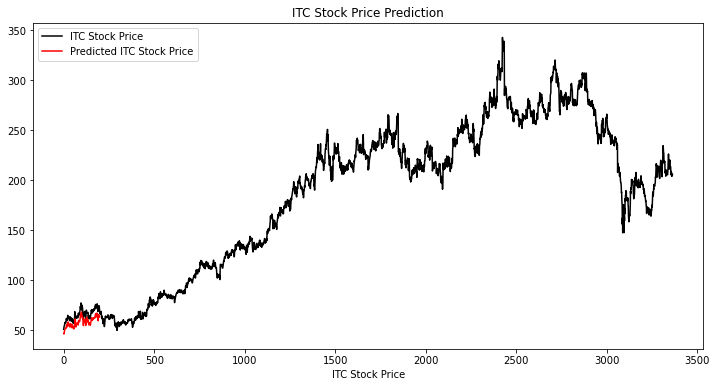

In [48]:
plt.figure(figsize=(12, 6))

plt.plot(real_stock_price, color='black', label='ITC Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted ITC Stock Price')

plt.title('ITC Stock Price Prediction')
plt.xlabel('Time')
plt.xlabel('ITC Stock Price')
plt.legend()
plt.show()